In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict
import nltk
from nltk.tokenize import word_tokenize

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

In [2]:
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

def count_tokens(text):
    tokens = word_tokenize(text.lower())
    return len(tokens)

In [3]:
def create_categories(token_counts, num_categories=4):
    if not token_counts:
        return []

    valid_counts = [count for count in token_counts if count > 0]
    
    if not valid_counts:
        return []
    
    min_tokens = min(valid_counts)
    max_tokens = max(valid_counts)

    if min_tokens == max_tokens:
        return [(min_tokens, max_tokens)]
    
    # Use quantiles for more balanced distribution
    try:
        percentiles = np.linspace(0, 100, num_categories + 1)
        thresholds = np.percentile(valid_counts, percentiles)
        
        # Ensure unique thresholds
        thresholds = np.unique(thresholds)
        
        categories = []
        for i in range(len(thresholds) - 1):
            start = int(np.floor(thresholds[i]))
            end = int(np.ceil(thresholds[i + 1]))
            
            # Avoid overlapping categories
            if i > 0 and start <= categories[-1][1]:
                start = categories[-1][1] + 1
            
            if start <= end:
                categories.append((start, end))
        
        # If we have fewer categories than requested due to data distribution
        # ensure the last category covers all remaining values
        if categories and categories[-1][1] < max_tokens:
            categories[-1] = (categories[-1][0], max_tokens)
            
    except Exception as e:
        print(f"Error creating quantile-based categories: {e}")
        # Fallback to equal-width binning
        bin_width = (max_tokens - min_tokens) / num_categories
        categories = []
        for i in range(num_categories):
            start = int(min_tokens + i * bin_width)
            end = int(min_tokens + (i + 1) * bin_width) if i < num_categories - 1 else max_tokens
            categories.append((start, end))
    
    return categories

In [4]:
def categorize_token_length(token_count, categories):
    for start, end in categories:
        if start <= token_count <= end:
            if start == end:
                return f'{start}'
            else:
                return f'{start}-{end}'
    
    # if not in any category, assign to the closest one
    if token_count < categories[0][0]:
        start, end = categories[0]
        return f'{start}-{end}' if start != end else f'{start}'
    else:
        start, end = categories[-1]
        return f'{start}-{end}' if start != end else f'{start}'

In [5]:
def process_data(data, num_categories=4):
    # First pass: calculate all token counts
    token_counts = []
    for item in data:
        token_count = count_tokens(item['question']) + count_tokens(item['code'])
        token_counts.append(token_count)
    
    # Create adaptive categories
    categories = create_categories(token_counts, num_categories)
    
    if not categories:
        print("Warning: Could not create categories from data")
        return {}, []
    
    print(f"Created {len(categories)} adaptive categories:")
    for i, (start, end) in enumerate(categories):
        if start == end:
            print(f"  Category {i+1}: {start} tokens")
        else:
            print(f"  Category {i+1}: {start}-{end} tokens")
    
    # Second pass: assign items to categories and calculate metrics
    for i, item in enumerate(data):
        item['token_count'] = token_counts[i]
        item['token_category'] = categorize_token_length(token_counts[i], categories)
    
    # Group by token categories
    grouped_data = defaultdict(list)
    for item in data:
        grouped_data[item['token_category']].append(item)
    
    # Create ordered list of category names
    category_names = []
    for start, end in categories:
        if start == end:
            category_names.append(f'{start}')
        else:
            category_names.append(f'{start}-{end}')
    
    results = {}
    for category in category_names:
        if category in grouped_data:
            items = grouped_data[category]
            
            # Filter out None values before calculating means
            accuracy_scores = [item['accuracy']['score'] for item in items if item['accuracy']['score'] is not None]
            completeness_scores = [item['completeness']['score'] for item in items if item['completeness']['score'] is not None]
            relevance_scores = [item['relevance']['score'] for item in items if item['relevance']['score'] is not None]
            clarity_scores = [item['clarity']['score'] for item in items if item['clarity']['score'] is not None]
            
            results[category] = {
                'accuracy': np.mean(accuracy_scores) if accuracy_scores else 0,
                'completeness': np.mean(completeness_scores) if completeness_scores else 0,
                'relevance': np.mean(relevance_scores) if relevance_scores else 0,
                'clarity': np.mean(clarity_scores) if clarity_scores else 0,
                'count': len(items)
            }
        else:
            # Category exists but has no data
            results[category] = {
                'accuracy': 0,
                'completeness': 0,
                'relevance': 0,
                'clarity': 0,
                'count': 0
            }
    
    return results, category_names

In [6]:
def create_figure_plot(processed_data, category_names, save_path=None):
    metrics = ['accuracy', 'completeness', 'relevance', 'clarity']
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Use a color palette that works well with varying numbers of categories
    colors = plt.cm.Set2(np.linspace(0, 1, len(category_names)))
    
    # Set up bar positions
    x = np.arange(len(metrics))
    width = 0.8 / len(category_names)  # Adjust width based on number of categories
    
    # Create bars for each token length category
    for i, category in enumerate(category_names):
        if category in processed_data:
            scores = [
                processed_data[category]['accuracy'],
                processed_data[category]['completeness'],
                processed_data[category]['relevance'],
                processed_data[category]['clarity']
            ]
            
            bars = ax.bar(x + i * width - (len(category_names) - 1) * width / 2, 
                         scores, width, 
                         label=f'{category} tokens', color=colors[i], alpha=0.8)
    
    ax.set_xlabel('Metrics', fontsize=14)
    ax.set_ylabel('Score', fontsize=14)
    ax.set_title(f'Performance of CodeLlama over various question token length for CS1QA', 
                fontsize=16, pad=20)
    
    # Set x-axis labels
    ax.set_xticks(x)
    ax.set_xticklabels(['Accuracy', 'Completeness', 'Relevance', 'Clarity'], 
                       fontsize=12)
    
    # Set y-axis
    ax.set_ylim(0, 5)
    ax.set_yticks(np.arange(0, 6, 1))
    ax.tick_params(axis='y', labelsize=12)
    
    # Add grid lines
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    
    # Add legend
    ax.legend(title='Token Length Range', title_fontsize=12, fontsize=11, 
              loc='upper left', bbox_to_anchor=(0, 1))
    
    # Adjust layout
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
    
    plt.show()
    
    return fig, ax

In [7]:
def display_statistics(processed_data, category_names):
    print("Detailed Performance Statistics by Token Length Category:")
    print("=" * 60)
    
    total_questions = sum(data['count'] for data in processed_data.values())
    print(f"\nTotal questions analyzed: {total_questions}")
    
    for category in category_names:
        if category in processed_data:
            data = processed_data[category]
            if data['count'] > 0:
                print(f"\nToken Length Range: {category} ({data['count']} questions)")
                print(f"  Accuracy:     {data['accuracy']:.2f}")
                print(f"  Completeness: {data['completeness']:.2f}")
                print(f"  Relevance:    {data['relevance']:.2f}")
                print(f"  Clarity:      {data['clarity']:.2f}")
            else:
                print(f"\nToken Length Range: {category} (0 questions)")
                print("  No data available")

Loaded 5543 questions
Created 5 adaptive categories:
  Category 1: 11-137 tokens
  Category 2: 138-208 tokens
  Category 3: 209-439 tokens
  Category 4: 440-1280 tokens
  Category 5: 1281-4496 tokens

Data distribution by adaptive token length categories:
11-137: 1137 questions
138-208: 1083 questions
209-439: 1108 questions
440-1280: 1107 questions
1281-4496: 1108 questions
Plot saved to RQ2_CS1QA_mistral.png


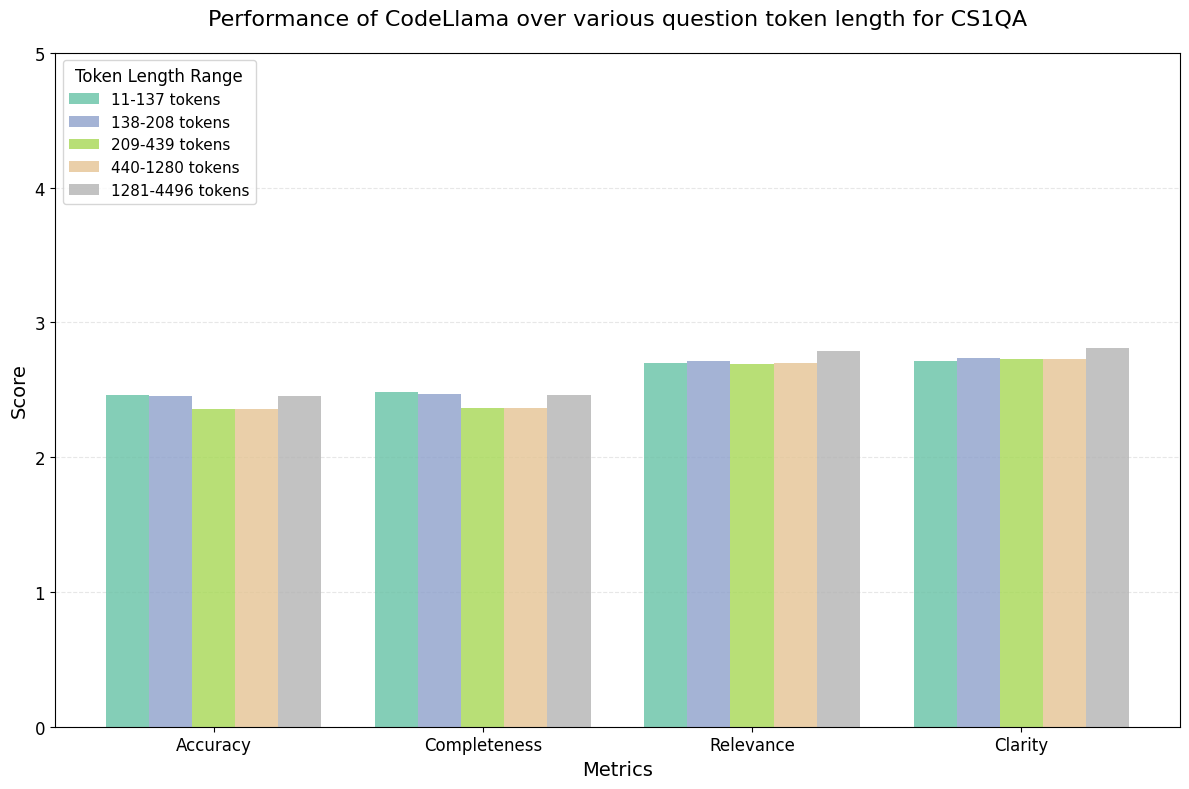

Detailed Performance Statistics by Token Length Category:

Total questions analyzed: 5543

Token Length Range: 11-137 (1137 questions)
  Accuracy:     2.46
  Completeness: 2.49
  Relevance:    2.70
  Clarity:      2.72

Token Length Range: 138-208 (1083 questions)
  Accuracy:     2.45
  Completeness: 2.47
  Relevance:    2.72
  Clarity:      2.74

Token Length Range: 209-439 (1108 questions)
  Accuracy:     2.35
  Completeness: 2.36
  Relevance:    2.69
  Clarity:      2.72

Token Length Range: 440-1280 (1107 questions)
  Accuracy:     2.36
  Completeness: 2.36
  Relevance:    2.70
  Clarity:      2.73

Token Length Range: 1281-4496 (1108 questions)
  Accuracy:     2.45
  Completeness: 2.46
  Relevance:    2.79
  Clarity:      2.81


In [ ]:
if __name__ == "__main__":
    # Load and process data
    file_path = 'CS1QA_Codellama_student_evaluations.json'
    dataset = load_data(file_path)
#     raw_data = load_data(file_path)
#     chunk_size = 5
#     dataset = raw_data[3*chunk_size:5*chunk_size]
    
    print(f"Loaded {len(dataset)} questions")
    
    # Process data with adaptive categories (you can change num_categories as needed)
    processed_data, category_names = process_data(dataset, num_categories=5)
    
    print(f"\nData distribution by adaptive token length categories:")
    for category in category_names:
        if category in processed_data:
            print(f"{category}: {processed_data[category]['count']} questions")
    
    # Create the plot
    fig, ax = create_figure_plot(
        processed_data, 
        category_names, 
        save_path='RQ2_CS1QA_mistral.png'
    )
    
    # Display detailed statistics
    display_statistics(processed_data, category_names)